In [57]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

In [107]:
matches.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,total_runs,total_wickets
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,23,13,7,13,...,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,304,13
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,40,5,0,0,...,Chennai Super Kings,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,447,9
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,16,2,11,11,...,Delhi Daredevils,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,261,9
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,55,9,13,9,...,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,331,12
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,14,7,1,1,...,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,222,15


In [5]:
# Fill missing values in the matches dataset
matches = matches.fillna({
    'city': 'Unknown',
    'player_of_match': 'No Award',
    'winner': 'No Result',
    'result_margin': 0,
    'target_runs': 0,
    'target_overs': 0
})

In [7]:
# Drop the 'method' column if it exists
if 'method' in matches.columns:
    matches = matches.drop(columns=['method'])

In [9]:
# Fill missing values in the deliveries dataset
deliveries = deliveries.fillna({
    'extras_type': 'None',
    'player_dismissed': 'None',
    'dismissal_kind': 'None',
    'fielder': 'None'
})

In [11]:
# Drop rows where 'winner' is 'No Result'
matches = matches[matches['winner'] != 'No Result']

In [13]:
# Standardize team names
team_name_corrections = {
    'Delhi Capitals': 'Delhi Daredevils',
    'Punjab Kings': 'Kings XI Punjab',
    'Rising Pune Supergiant': 'Rising Pune Supergiants',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore'
}
matches = matches.replace({'team1': team_name_corrections, 'team2': team_name_corrections, 'toss_winner': team_name_corrections, 'winner': team_name_corrections})


## Visualization:

### Number of Matches Played by Each Team

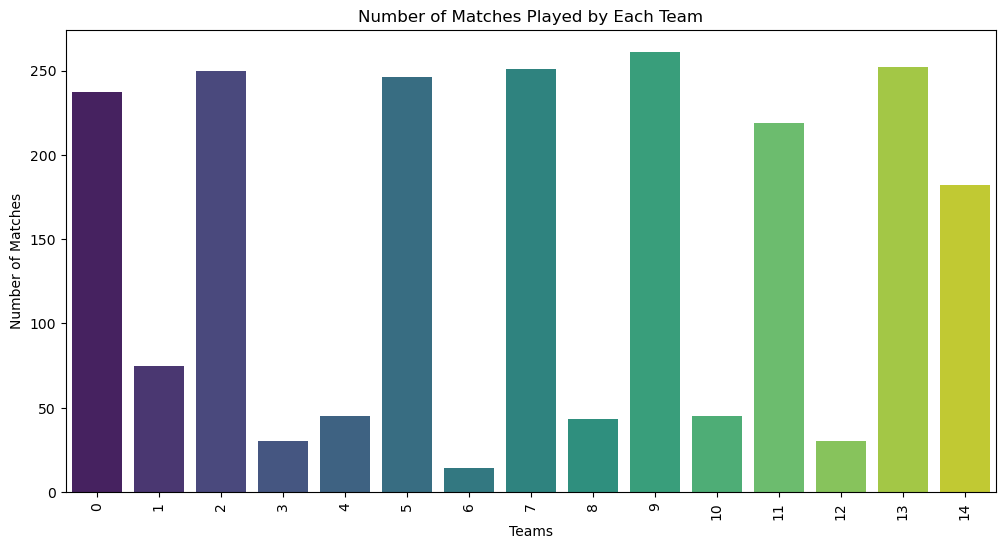

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of matches played by each team
team_matches = matches['team1'].value_counts() + matches['team2'].value_counts()
team_names = team_matches.index

plt.figure(figsize=(12, 6))
sns.barplot(x=team_names, y=team_matches.values, palette='viridis')
plt.title('Number of Matches Played by Each Team')
plt.xlabel('Teams')
plt.ylabel('Number of Matches')
plt.xticks(rotation=90)
plt.show()

### Number of wins by each team:

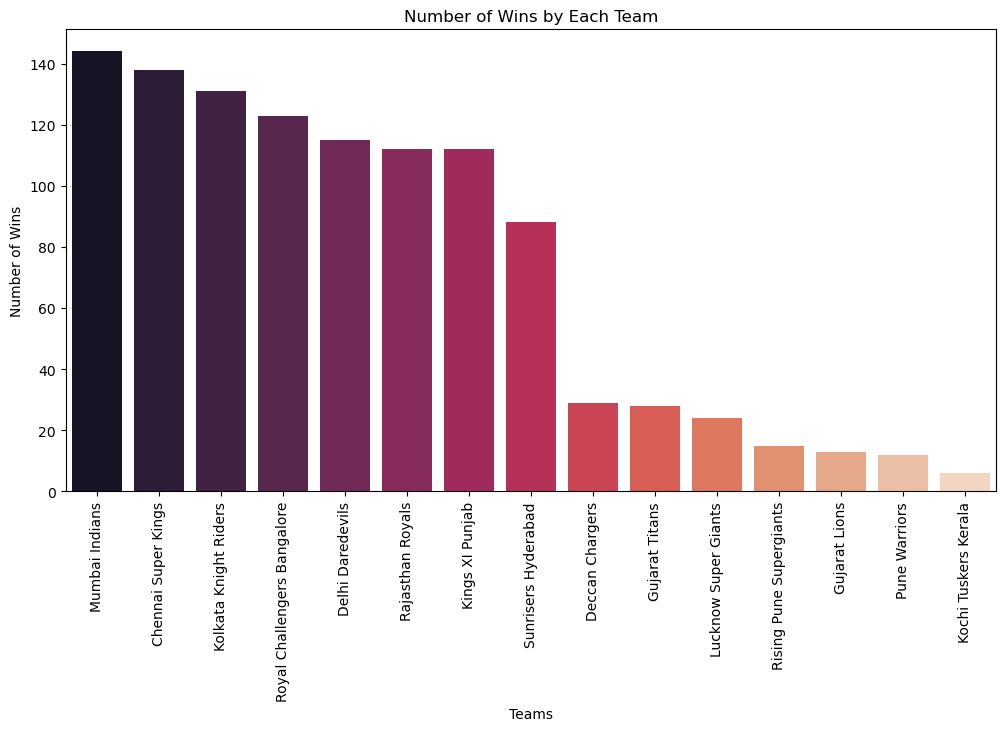

In [111]:
team_wins = matches['winner'].value_counts()
team_names_wins = team_wins.index

plt.figure(figsize=(12, 6))
sns.barplot(x=team_names_wins, y=team_wins.values, palette='rocket')
plt.title('Number of Wins by Each Team')
plt.xlabel('Teams')
plt.ylabel('Number of Wins')
plt.xticks(rotation=90)
plt.show()

### Toss decisions across seasons:

<Figure size 1200x600 with 0 Axes>

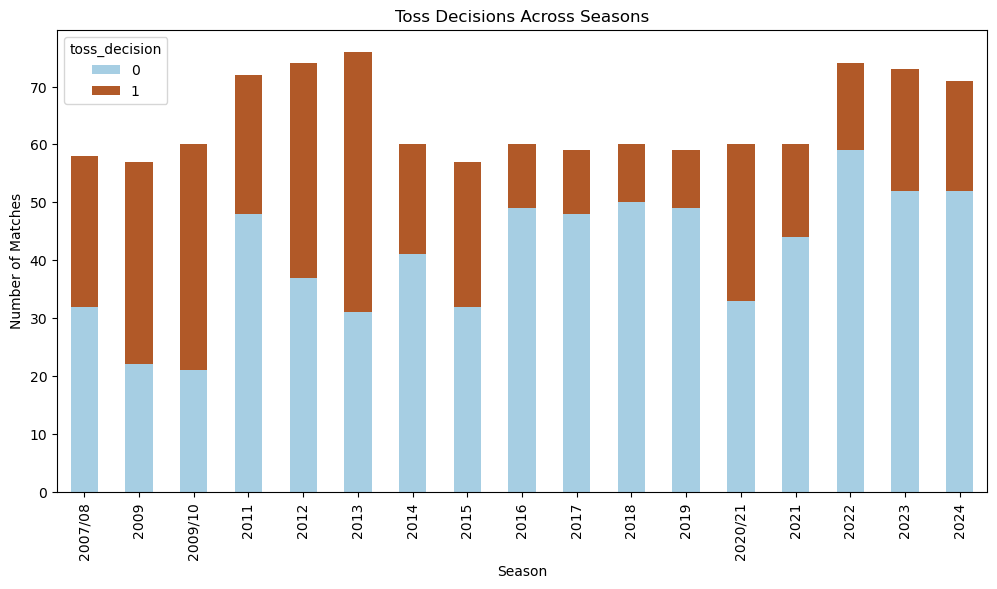

In [115]:
toss_decisions = matches.groupby('season')['toss_decision'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 6))
toss_decisions.plot(kind='bar', stacked=True, colormap='Paired', figsize=(12, 6))
plt.title('Toss Decisions Across Seasons')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.show()

### Match results by season:

<Figure size 1200x600 with 0 Axes>

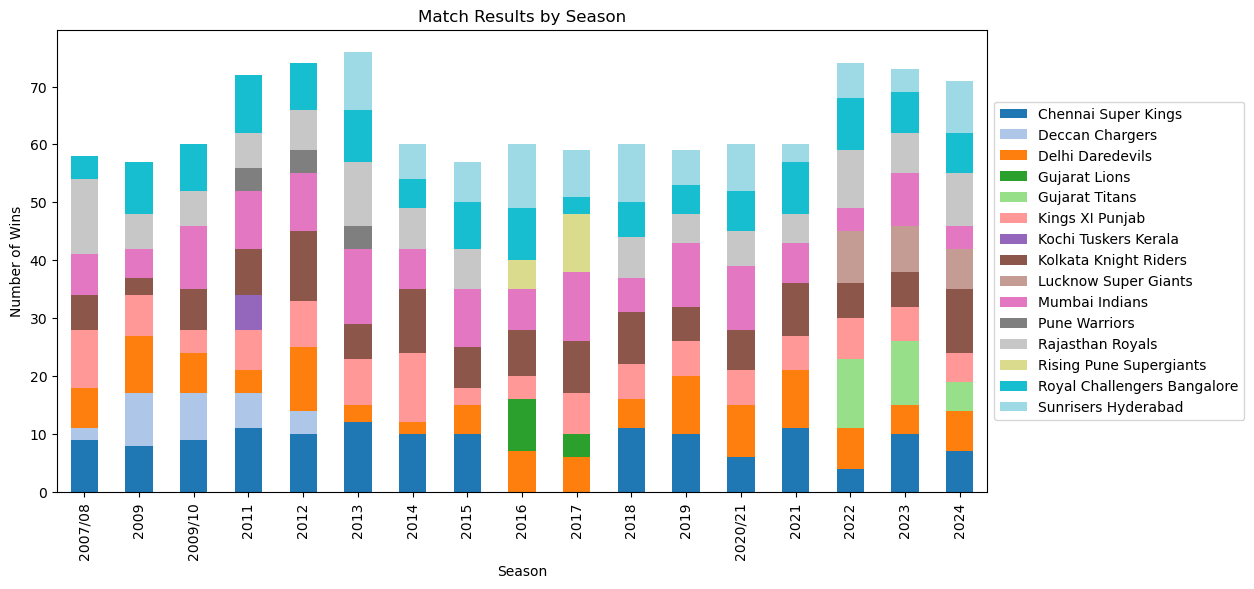

In [117]:
season_wins = matches.groupby('season')['winner'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 6))
season_wins.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Match Results by Season')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [15]:
# Calculate total runs and wickets per match from the deliveries dataset
match_runs = deliveries.groupby('match_id')['total_runs'].sum()
match_wickets = deliveries[deliveries['is_wicket'] == 1].groupby('match_id')['is_wicket'].count()

In [17]:
# Merge these features with the matches dataset
matches = matches.merge(match_runs.rename('total_runs'), left_on='id', right_index=True, how='left')
matches = matches.merge(match_wickets.rename('total_wickets'), left_on='id', right_index=True, how='left').fillna(0)

In [19]:
# Load the original matches dataset to get the original team names
matches_original = pd.read_csv('matches.csv')
matches_original = matches_original.replace({'team1': team_name_corrections, 'team2': team_name_corrections, 'toss_winner': team_name_corrections, 'winner': team_name_corrections})

In [21]:
# Extract unique team names
unique_teams_original = pd.concat([matches_original['team1'], matches_original['team2'], matches_original['toss_winner'], matches_original['winner']]).unique()

In [23]:
# Refit the label encoder with all unique team names
label_encoder = LabelEncoder()
label_encoder.fit(unique_teams_original)

LabelEncoder()

In [25]:
# Encode categorical variables in matches
matches['team1'] = label_encoder.transform(matches['team1'])
matches['team2'] = label_encoder.transform(matches['team2'])
matches['toss_winner'] = label_encoder.transform(matches['toss_winner'])

In [27]:
# Encode the toss_decision as it's a categorical variable
matches['toss_decision'] = matches['toss_decision'].apply(lambda x: 1 if x == 'bat' else 0)

In [29]:
# Extract unique venue names and fit the encoder
unique_venues = matches['venue'].unique()
venue_encoder = LabelEncoder()
venue_encoder.fit(unique_venues)
matches['venue'] = venue_encoder.transform(matches['venue'])

In [31]:
# Select relevant features for the model
features = ['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'total_runs', 'total_wickets']
target = 'winner'

In [33]:
# Encode the target variable with original team names
matches['winner'] = matches_original['winner'].replace(team_name_corrections)
y = matches['winner']
y_encoded = label_encoder.transform(y)

In [35]:
# Split the data into training and testing sets
X = matches[features]

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train[['total_runs', 'total_wickets']] = scaler.fit_transform(X_train[['total_runs', 'total_wickets']])
X_test[['total_runs', 'total_wickets']] = scaler.transform(X_test[['total_runs', 'total_wickets']])

In [37]:
# Function to train and evaluate a model
def evaluate_model(model):
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    report = classification_report(y_test_encoded, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    return accuracy, precision, recall, f1, report, conf_matrix

In [39]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Random Forest Classifier:
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.5412844036697247
Precision: 0.5087990943942515
Recall: 0.5412844036697247
F1 Score: 0.5049442616552149
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.84      0.76        37
           1       0.50      0.50      0.50         2
           2       0.41      0.35      0.38        20
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         9
           5       0.46      0.30      0.36        20
           6       0.00      0.00      0.00         2
           7       0.52      0.61      0.56        23
           8       1.00      0.33      0.50         3
           9       0.50      0.73      0.59        26
          10       0.00      0.00      0.00         3
          11       0.52      0.48      0.50        25
          12       0.00      0.00      0.00         

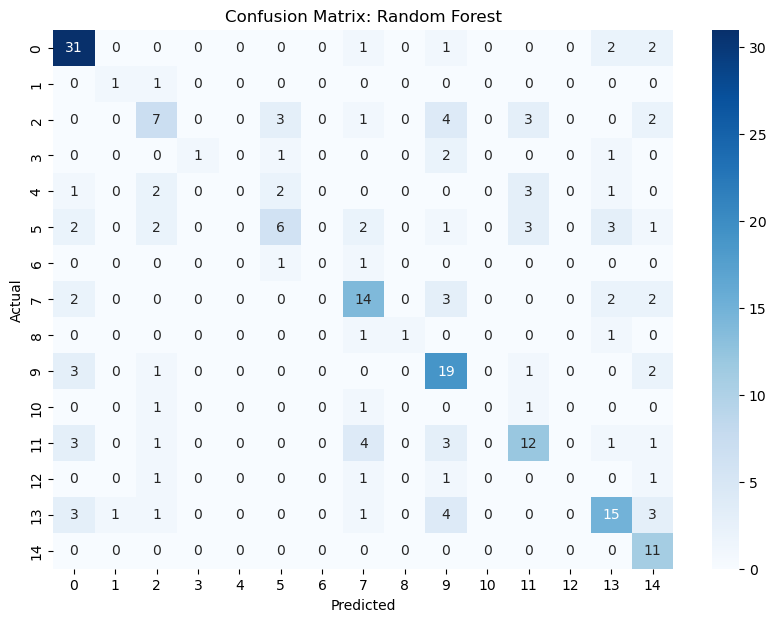

In [55]:
# Random Forest Classifier with Grid Search
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_report, rf_conf_matrix = evaluate_model(rf_grid)
print("Random Forest Classifier:")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Classification Report: \n{rf_report}")
plot_confusion_matrix(rf_conf_matrix, 'Random Forest')


Gradient Boosting Classifier:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.5688073394495413
Precision: 0.5671140097935097
Recall: 0.5688073394495413
F1 Score: 0.5615787672979289
Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        37
           1       0.50      1.00      0.67         2
           2       0.33      0.25      0.29        20
           3       1.00      0.60      0.75         5
           4       0.88      0.78      0.82         9
           5       0.42      0.40      0.41        20
           6       0.00      0.00      0.00         2
           7       0.57      0.57      0.57        23
           8       0.75      1.00      0.86         3
           9       0.53      0.62      0.57        26
          10       0.00      0.00      0.00         3
          11       0.64      0.56      0.60        25
          12       1.00      0.50      0.67      

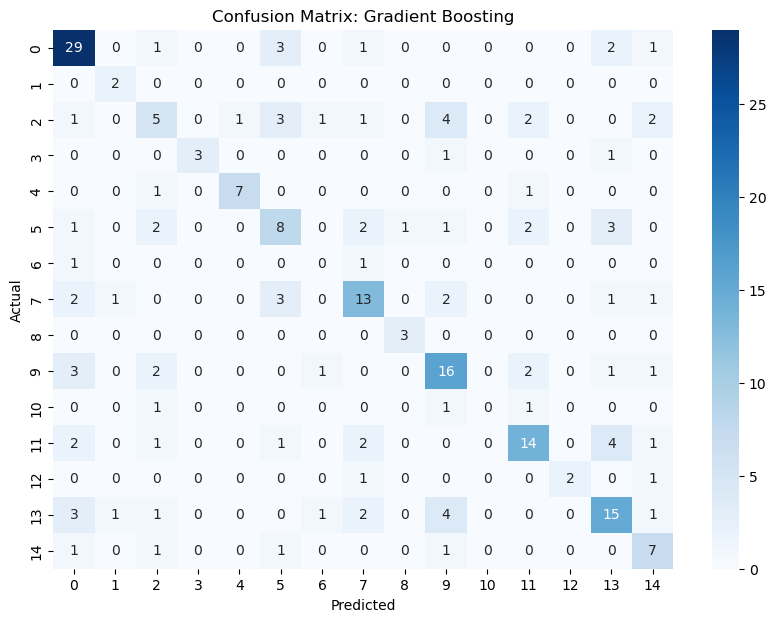

In [59]:
# Gradient Boosting Classifier with Grid Search
gb = GradientBoostingClassifier(random_state=42)
gb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_accuracy, gb_precision, gb_recall, gb_f1, gb_report, gb_conf_matrix = evaluate_model(gb_grid)
print("\nGradient Boosting Classifier:")
print(f"Best Parameters: {gb_grid.best_params_}")
print(f"Accuracy: {gb_accuracy}")
print(f"Precision: {gb_precision}")
print(f"Recall: {gb_recall}")
print(f"F1 Score: {gb_f1}")
print(f"Classification Report: \n{gb_report}")
plot_confusion_matrix(gb_conf_matrix, 'Gradient Boosting')


XGBoost Classifier:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.5779816513761468
Precision: 0.5806773582244016
Recall: 0.5779816513761468
F1 Score: 0.5704024544498195
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        37
           1       0.50      1.00      0.67         2
           2       0.38      0.30      0.33        20
           3       1.00      0.40      0.57         5
           4       0.86      0.67      0.75         9
           5       0.50      0.50      0.50        20
           6       0.00      0.00      0.00         2
           7       0.55      0.52      0.53        23
           8       0.75      1.00      0.86         3
           9       0.55      0.69      0.61        26
          10       0.00      0.00      0.00         3
          11       0.64      0.56      0.60        25
          12       0.67      0.50      0.57         4
      

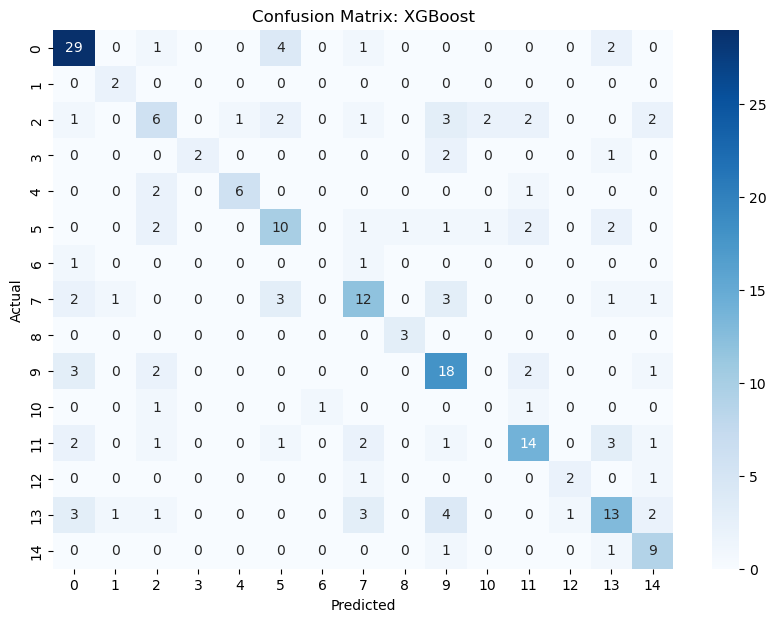

In [60]:
# XGBoost Classifier with Grid Search
xgb = XGBClassifier(random_state=42)
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_report, xgb_conf_matrix = evaluate_model(xgb_grid)
print("\nXGBoost Classifier:")
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"Accuracy: {xgb_accuracy}")
print(f"Precision: {xgb_precision}")
print(f"Recall: {xgb_recall}")
print(f"F1 Score: {xgb_f1}")
print(f"Classification Report: \n{xgb_report}")
plot_confusion_matrix(xgb_conf_matrix, 'XGBoost')


Neural Network Classifier:
Best Parameters: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 200}
Accuracy: 0.3394495412844037
Precision: 0.2970953522252897
Recall: 0.3394495412844037
F1 Score: 0.2960747560779235
Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        37
           1       0.00      0.00      0.00         2
           2       0.23      0.15      0.18        20
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         9
           5       0.18      0.10      0.13        20
           6       0.00      0.00      0.00         2
           7       0.37      0.30      0.33        23
           8       0.00      0.00      0.00         3
           9       0.22      0.50      0.31        26
          10       0.00      0.00      0.00         3
          11       0.25      0.04      0.07        25
          12       0.00      0.00    

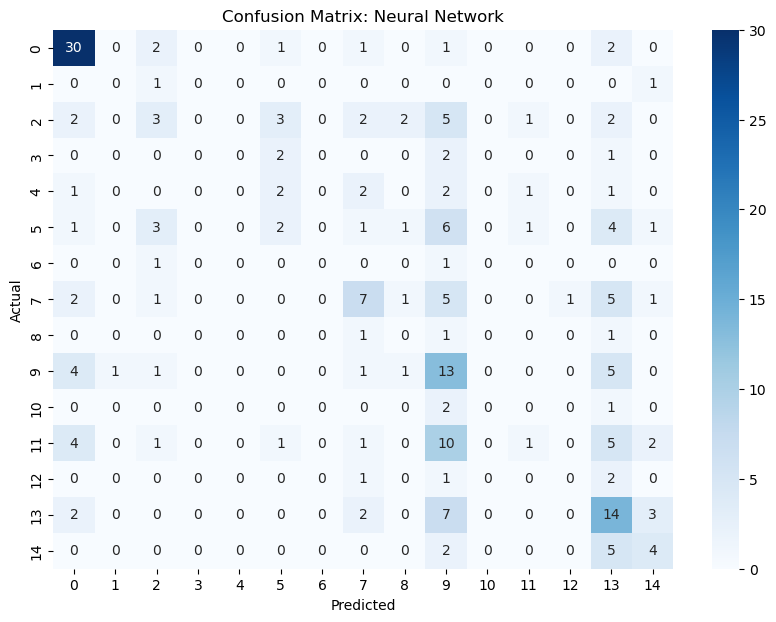

In [61]:
# Neural Network Classifier with Grid Search
mlp = MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=10)
mlp_params = {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'learning_rate_init': [0.001, 0.01], 'max_iter': [200, 300, 500]}
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1)
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_report, mlp_conf_matrix = evaluate_model(mlp_grid)
print("\nNeural Network Classifier:")
print(f"Best Parameters: {mlp_grid.best_params_}")
print(f"Accuracy: {mlp_accuracy}")
print(f"Precision: {mlp_precision}")
print(f"Recall: {mlp_recall}")
print(f"F1 Score: {mlp_f1}")
print(f"Classification Report: \n{mlp_report}")
plot_confusion_matrix(mlp_conf_matrix, 'Neural Network')


Support Vector Machine Classifier:
Best Parameters: {'C': 1.6601864044243653, 'gamma': 0.16599452033620266}
Accuracy: 0.3944954128440367
Precision: 0.41554053794339824
Recall: 0.3944954128440367
F1 Score: 0.3906078502171941
Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.46      0.53        37
           1       0.00      0.00      0.00         2
           2       0.22      0.35      0.27        20
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         9
           5       0.35      0.45      0.39        20
           6       0.00      0.00      0.00         2
           7       0.43      0.43      0.43        23
           8       0.50      0.33      0.40         3
           9       0.35      0.46      0.40        26
          10       0.00      0.00      0.00         3
          11       0.59      0.40      0.48        25
          12       0.00      0.00      0.00     

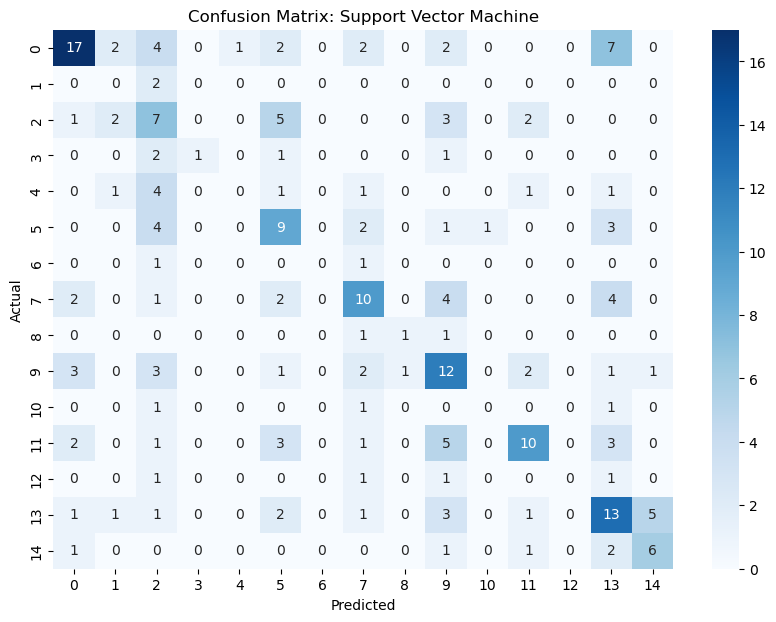

In [62]:
# Support Vector Machine with Randomized Search
svc = SVC(random_state=42)
svc_params = {'C': uniform(0.1, 10), 'gamma': uniform(0.01, 1)}
svc_random = RandomizedSearchCV(svc, svc_params, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
svc_accuracy, svc_precision, svc_recall, svc_f1, svc_report, svc_conf_matrix = evaluate_model(svc_random)
print("\nSupport Vector Machine Classifier:")
print(f"Best Parameters: {svc_random.best_params_}")
print(f"Accuracy: {svc_accuracy}")
print(f"Precision: {svc_precision}")
print(f"Recall: {svc_recall}")
print(f"F1 Score: {svc_f1}")
print(f"Classification Report: \n{svc_report}")
plot_confusion_matrix(svc_conf_matrix, 'Support Vector Machine')


K-Nearest Neighbors Classifier:
Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.42660550458715596
Precision: 0.4446247319402442
Recall: 0.42660550458715596
F1 Score: 0.42667522298303723
Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        37
           1       0.00      0.00      0.00         2
           2       0.28      0.35      0.31        20
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         9
           5       0.35      0.35      0.35        20
           6       0.00      0.00      0.00         2
           7       0.30      0.35      0.32        23
           8       0.20      0.33      0.25         3
           9       0.45      0.50      0.47        26
          10       0.50      0.33      0.40         3
          11       0.68      0.52      0.59        25
          12       1.00      0.25      0.40         4
         

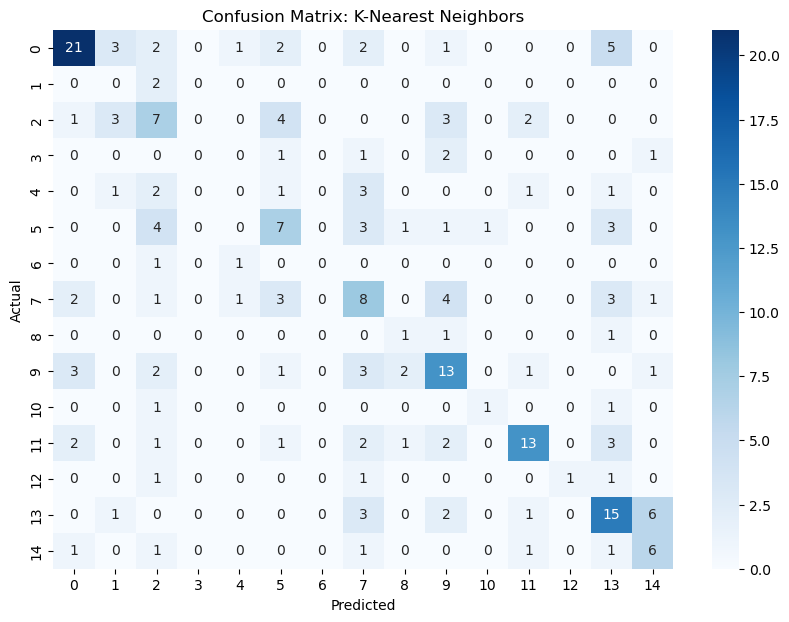

In [63]:
# K-Nearest Neighbors with Randomized Search
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': randint(1, 30), 'weights': ['uniform', 'distance']}
knn_random = RandomizedSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
knn_accuracy, knn_precision, knn_recall, knn_f1, knn_report, knn_conf_matrix = evaluate_model(knn_random)
print("\nK-Nearest Neighbors Classifier:")
print(f"Best Parameters: {knn_random.best_params_}")
print(f"Accuracy: {knn_accuracy}")
print(f"Precision: {knn_precision}")
print(f"Recall: {knn_recall}")
print(f"F1 Score: {knn_f1}")
print(f"Classification Report: \n{knn_report}")
plot_confusion_matrix(knn_conf_matrix, 'K-Nearest Neighbors')


Naive Bayes Classifier:
Accuracy: 0.23853211009174313
Precision: 0.2485423205195196
Recall: 0.23853211009174313
F1 Score: 0.23393085037793312
Classification Report: 
              precision    recall  f1-score   support

           0       0.52      0.38      0.44        37
           1       0.00      0.00      0.00         2
           2       0.10      0.20      0.14        20
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         9
           5       0.07      0.05      0.06        20
           6       0.07      1.00      0.13         2
           7       0.06      0.04      0.05        23
           8       0.00      0.00      0.00         3
           9       0.32      0.31      0.31        26
          10       0.00      0.00      0.00         3
          11       0.31      0.20      0.24        25
          12       0.00      0.00      0.00         4
          13       0.39      0.50      0.44        28
          14       0.2

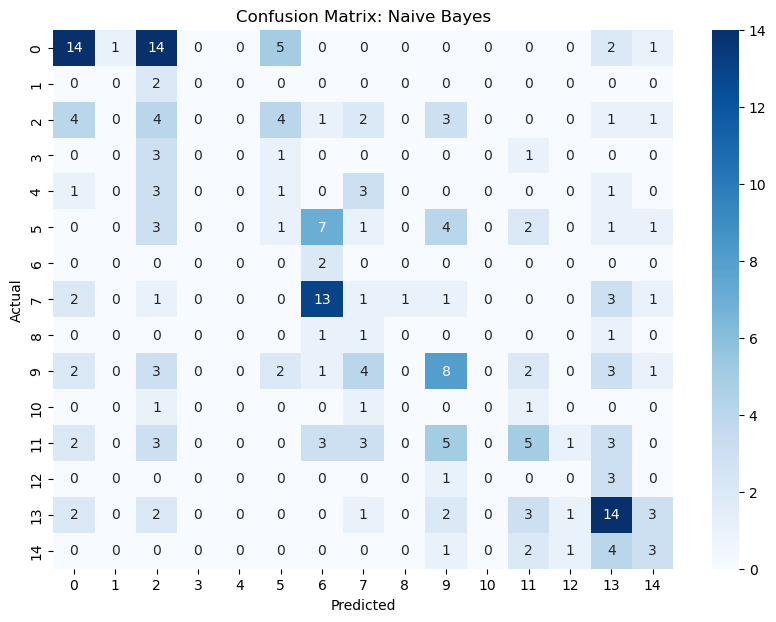

In [71]:
# Naive Bayes Classifier
nb = GaussianNB()
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_report, nb_conf_matrix = evaluate_model(nb)
print("\nNaive Bayes Classifier:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1 Score: {nb_f1}")
print(f"Classification Report: \n{nb_report}")
plot_confusion_matrix(nb_conf_matrix, 'Naive Bayes')

In [89]:

import pandas as pd

# Create a dictionary to store the results
results = {
    'Model': [
        'Random Forest', 'Gradient Boosting', 'XGBoost',
        'Neural Network', 'Support Vector Machine', 'K-Nearest Neighbors', 'Naive Bayes'
    ],
    'Best Parameters': [
        "{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}",
        "{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}",
        "{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",
        "{'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 200}",
        "{'C': 1.6601864044243653, 'gamma': 0.16599452033620266}",
        "{'n_neighbors': 7, 'weights': 'distance'}",
        "N/A"
    ],
    'Accuracy': [
        0.5412844036697247, 0.5688073394495413, 0.5779816513761468,
        0.3394495412844037, 0.3944954128440367, 0.42660550458715596, 0.23853211009174313
    ],
    'Precision': [
        0.5087990943942515, 0.5671140097935097, 0.5806773582244016,
        0.2970953522252897, 0.41554053794339824, 0.4446247319402442, 0.2485423205195196
    ],
    'Recall': [
        0.5412844036697247, 0.5688073394495413, 0.5779816513761468,
        0.3394495412844037, 0.3944954128440367, 0.42667522298303723, 0.23853211009174313
    ],
    'F1 Score': [
        0.5049442616552149, 0.5615787672979289, 0.5704024544498195,
        0.2960747560779235, 0.3906078502171941, 0.42667522298303723, 0.23393085037793312
    ]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Determine the best model based on accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]

# Print the consolidated results and the best model
print("Consolidated Results:\n", results_df)
print("\nBest Model Based on Accuracy:\n", best_model)

Consolidated Results:
                     Model                                    Best Parameters  \
0           Random Forest  {'max_depth': 10, 'min_samples_split': 2, 'n_e...   
1       Gradient Boosting  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   
2                 XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
3          Neural Network  {'hidden_layer_sizes': (100,), 'learning_rate_...   
4  Support Vector Machine  {'C': 1.6601864044243653, 'gamma': 0.165994520...   
5     K-Nearest Neighbors          {'n_neighbors': 7, 'weights': 'distance'}   
6             Naive Bayes                                                N/A   

   Accuracy  Precision    Recall  F1 Score  
0  0.541284   0.508799  0.541284  0.504944  
1  0.568807   0.567114  0.568807  0.561579  
2  0.577982   0.580677  0.577982  0.570402  
3  0.339450   0.297095  0.339450  0.296075  
4  0.394495   0.415541  0.394495  0.390608  
5  0.426606   0.444625  0.426675  0.426675  
6  0.238532   0.24854

In [91]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

# Assuming X_train and scaler are already defined from the previous code
# Define the teams participating in IPL 2025
teams_2025 = [
    'Chennai Super Kings', 'Delhi Capitals', 'Kings XI Punjab',
    'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals',
    'Royal Challengers Bangalore', 'Sunrisers Hyderabad', 'Gujarat Titans', 'Lucknow Super Giants'
]

# Fit the label encoder with only the current teams
label_encoder_2025 = LabelEncoder()
label_encoder_2025.fit(teams_2025)

# Encode the teams using the updated label encoder
teams_2025_encoded = label_encoder_2025.transform(teams_2025)

# Prepare hypothetical matchups for the 2025 season
matchups = []
for team1 in teams_2025_encoded:
    for team2 in teams_2025_encoded:
        if team1 != team2:
            match = {
                'team1': team1,
                'team2': team2,
                'toss_winner': team1,  # Assume team1 wins the toss
                'toss_decision': 0,  # Assume team1 decides to field
                'venue': 0,  # Assume a default venue (first in the list)
                'total_runs': np.mean(X_train['total_runs']),  # Average runs
                'total_wickets': np.mean(X_train['total_wickets'])  # Average wickets
            }
            matchups.append(match)

# Convert matchups to DataFrame
matchups_df = pd.DataFrame(matchups)

# Scale the numerical features
matchups_df[['total_runs', 'total_wickets']] = scaler.transform(matchups_df[['total_runs', 'total_wickets']])

# Define the best XGBoost model with the specified parameters
best_xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

# Train the model on the original training data
best_xgb_model.fit(X_train, y_train_encoded)

# Predict the outcomes of the matchups using the best XGBoost model
predictions = best_xgb_model.predict(matchups_df)

# Decode the predicted winner labels using the updated label encoder
predicted_winners = label_encoder_2025.inverse_transform(predictions)

# Aggregate the results to determine the most likely winner
winner_counts = pd.Series(predicted_winners).value_counts()
most_likely_winner = winner_counts.idxmax()

print("Predicted match outcomes:")
print(pd.Series(predicted_winners).value_counts())

print(f"\nThe most likely winner of IPL 2025 is: {most_likely_winner}")

# Display the winner counts for each team
print("\nWinner counts for each team:")
print(winner_counts)

Predicted match outcomes:
Lucknow Super Giants           16
Sunrisers Hyderabad            14
Gujarat Titans                 12
Chennai Super Kings            10
Kolkata Knight Riders           9
Kings XI Punjab                 9
Delhi Capitals                  7
Rajasthan Royals                6
Mumbai Indians                  5
Royal Challengers Bangalore     2
Name: count, dtype: int64

The most likely winner of IPL 2025 is: Lucknow Super Giants

Winner counts for each team:
Lucknow Super Giants           16
Sunrisers Hyderabad            14
Gujarat Titans                 12
Chennai Super Kings            10
Kolkata Knight Riders           9
Kings XI Punjab                 9
Delhi Capitals                  7
Rajasthan Royals                6
Mumbai Indians                  5
Royal Challengers Bangalore     2
Name: count, dtype: int64


In [101]:
# Define the teams participating in IPL 2025
teams_2025 = [
    'Chennai Super Kings', 'Delhi Capitals', 'Kings XI Punjab',
    'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals',
    'Royal Challengers Bangalore', 'Sunrisers Hyderabad', 'Gujarat Titans', 'Lucknow Super Giants'
]

# Fit the label encoder with only the current teams
label_encoder_2025 = LabelEncoder()
label_encoder_2025.fit(teams_2025)

# Encode the teams using the updated label encoder
teams_2025_encoded = label_encoder_2025.transform(teams_2025)

# Prepare hypothetical matchups for the 2025 season
matchups = []
for team1 in teams_2025_encoded:
    for team2 in teams_2025_encoded:
        if team1 != team2:
            match = {
                'team1': team1,
                'team2': team2,
                'toss_winner': team1,  # Assume team1 wins the toss
                'toss_decision': 0,  # Assume team1 decides to field
                'venue': 0,  # Assume a default venue (first in the list)
                'total_runs': np.mean(X_train['total_runs']),  # Average runs
                'total_wickets': np.mean(X_train['total_wickets'])  # Average wickets
            }
            matchups.append(match)

# Convert matchups to DataFrame
matchups_df = pd.DataFrame(matchups)

# Scale the numerical features
matchups_df[['total_runs', 'total_wickets']] = scaler.transform(matchups_df[['total_runs', 'total_wickets']])

# Define the best XGBoost model with the specified parameters
best_xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

# Train the model on the original training data
best_xgb_model.fit(X_train, y_train_encoded)

# Predict the outcomes of the matchups using the best XGBoost model
predictions = best_xgb_model.predict(matchups_df)

# Decode the predicted winner labels using the updated label encoder
predicted_winners = label_encoder_2025.inverse_transform(predictions)

# Aggregate the results to determine the most likely winner
winner_counts = pd.Series(predicted_winners).value_counts()
most_likely_winner = winner_counts.idxmax()

# Calculate the percentage win chance for each team
total_matches = len(predicted_winners)
win_percentages = (winner_counts / total_matches) * 100

print("Predicted match outcomes:")
print(win_percentages)

print(f"\nThe most likely winner of IPL 2025 is: {most_likely_winner} with a win chance of {win_percentages[most_likely_winner]:.2f}%")

Predicted match outcomes:
Lucknow Super Giants           17.777778
Sunrisers Hyderabad            15.555556
Gujarat Titans                 13.333333
Chennai Super Kings            11.111111
Kolkata Knight Riders          10.000000
Kings XI Punjab                10.000000
Delhi Capitals                  7.777778
Rajasthan Royals                6.666667
Mumbai Indians                  5.555556
Royal Challengers Bangalore     2.222222
Name: count, dtype: float64

The most likely winner of IPL 2025 is: Lucknow Super Giants with a win chance of 17.78%
